# Mediators

We aim to investigate exactly how identified latent components affect other components.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import Tensor
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


In [4]:
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Loaded pretrained model gpt2-small into HookedTransformer


## Specific Example

For a specific example, we will ablate each component and measure the change in activations across all other components in the layer immediately downstream. We then analyse how much identified latent components change other components' activations.

### Experiment - measure change in activations per ablation

In [5]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to "
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to "
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([0.6779], device='cuda:0')
Corrupted logit difference: tensor([0.1698], device='cuda:0')


In [6]:
def activation_cache_to_tensor(model, activation_cache, get_attn: bool):
    """
    Convert the activation cache to a tensor of shape:
    - (num_layers, num_heads, d_model) for attention heads
    - (num_layers, d_model) for MLP heads
    """
    matrix = []
    for layer in range(model.cfg.n_layers):
        if get_attn:
            hook_name = get_act_name("result", layer)
        else:
            hook_name = get_act_name("post", layer)
        
        matrix.append(activation_cache[hook_name][0, -1])
    
    matrix = torch.stack(matrix, dim=0)
    return matrix

In [7]:
baseline_attn_cache = activation_cache_to_tensor(model, clean_cache, get_attn=True)
print("Baseline attention cache shape:", baseline_attn_cache.shape)

baseline_mlp_cache = activation_cache_to_tensor(model, clean_cache, get_attn=False)
print("Baseline MLP cache shape:", baseline_mlp_cache.shape)

Baseline attention cache shape: torch.Size([12, 12, 768])
Baseline MLP cache shape: torch.Size([12, 3072])


In [ ]:
# How much does each head affect other heads in other layers?
ablation_act_diff_attn = torch.zeros((model.cfg.n_layers * model.cfg.n_heads, model.cfg.n_layers, model.cfg.n_heads))

for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)

        def ablate_hook(act, hook):
            act[:, head] = corrupted_cache[hook.name][:, head]
            return act
        
        with model.hooks(fwd_hooks=[(hook_name, ablate_hook)]):
            _, patched_attn_cache = model.run_with_cache(clean_tokens)
        
        diff = activation_cache_to_tensor(model, patched_attn_cache, get_attn=True) - baseline_attn_cache
        print("Number of components with changed activations:", torch.count_nonzero(diff.mean(-1)).item())
        ablation_act_diff_attn[layer * model.cfg.n_heads + head] = diff.mean(dim=-1)

torch.save(ablation_act_diff_attn, "results/mediators/ablation_act_diff_attn.pt")


Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 101376
Number of components with changed activations: 101370
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of components with changed activations: 0
Number of 

In [ ]:
# How much does each neuron affect other neurons in other layers?
ablation_act_diff_mlp = torch.zeros((model.cfg.n_layers * model.cfg.d_mlp, model.cfg.n_layers, model.cfg.d_mlp))

for layer in range(model.cfg.n_layers):
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)

        def ablate_hook(act, hook):
            act[:, head] = corrupted_cache[hook.name][:, head]
            return act
        
        with model.hooks(fwd_hooks=[(hook_name, ablate_hook)]):
            _, patched_mlp_cache = model.run_with_cache(clean_tokens)
        
        diff = activation_cache_to_tensor(model, patched_mlp_cache, get_attn=False) - baseline_mlp_cache
        print("Number of components with changed activations:", torch.count_nonzero(diff).item())
        ablation_act_diff_mlp[layer * model.cfg.d_mlp + neuron] = diff

torch.save(ablation_act_diff_mlp, "results/mediators/ablation_act_diff_mlp.pt")


Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations: 33775
Number of components with changed activations:

### Experiment - identify outliers

In [ ]:
# Run integrated gradients in opposite directions

mlp_corrupt_clean, attn_corrupt_clean = integrated_gradients(
    model,
    clean_tokens,
    clean_cache,
    corrupted_cache,
    logit_diff_metric,
    labels
)

torch.save(mlp_corrupt_clean, "results/mediators/mlp_corrupt_clean.pt")
torch.save(attn_corrupt_clean, "results/mediators/attn_corrupt_clean.pt")

In [ ]:
mlp_clean_corrupt, attn_clean_corrupt = integrated_gradients(
    model,
    corrupted_tokens,
    corrupted_cache,
    clean_cache,
    logit_diff_metric,
    labels
)

torch.save(mlp_clean_corrupt, "results/mediators/mlp_clean_corrupt.pt")
torch.save(attn_clean_corrupt, "results/mediators/attn_clean_corrupt.pt")

In [8]:
mlp_clean_corrupt = torch.load("results/mediators/mlp_clean_corrupt.pt")
attn_clean_corrupt = torch.load("results/mediators/attn_clean_corrupt.pt")
mlp_corrupt_clean = torch.load("results/mediators/mlp_corrupt_clean.pt")
attn_corrupt_clean = torch.load("results/mediators/attn_corrupt_clean.pt")

In [44]:
# Identify latent components

mlp_latent = highlight_components(mlp_corrupt_clean + mlp_clean_corrupt)[0]
attn_latent = highlight_components(attn_corrupt_clean + attn_clean_corrupt)[0]

mlp_latent_indices = mlp_latent.nonzero()
attn_latent_indices = attn_latent.nonzero()

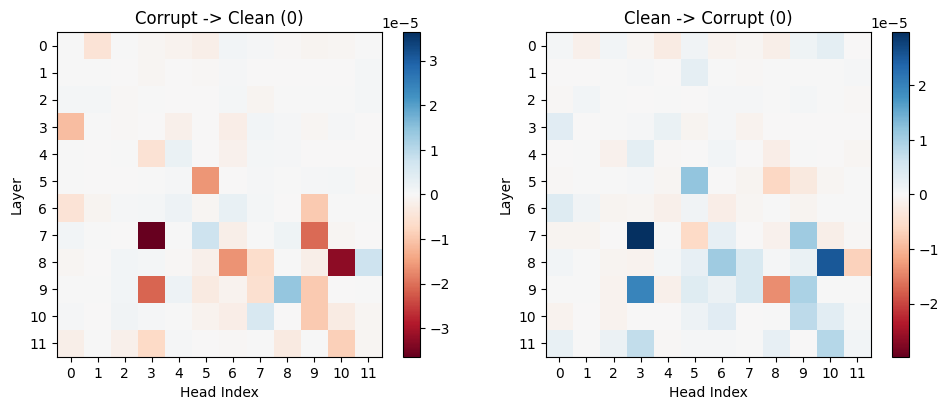

In [21]:
plot_attn_comparison(attn_corrupt_clean, attn_clean_corrupt, model, "Corrupt -> Clean", "Clean -> Corrupt")

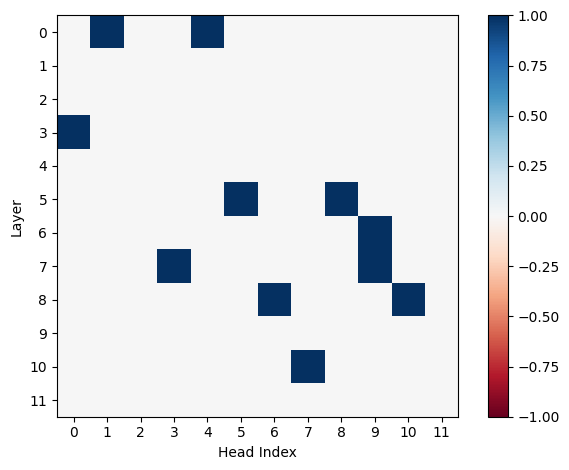

In [45]:
plot_attn(attn_latent[0].int(), model)

### Analysis

In [11]:
ablation_act_diff_attn = torch.load("results/mediators/ablation_act_diff_attn.pt")
ablation_act_diff_mlp = torch.load("results/mediators/ablation_act_diff_mlp.pt")

In [12]:
baseline_act_diff_attn = ablation_act_diff_attn.mean()
baseline_act_diff_mlp = ablation_act_diff_mlp.mean()

In [46]:
ablation_act_diff_attn.nonzero()

tensor([[ 10,   1,   0],
        [ 10,   1,   1],
        [ 10,   1,   2],
        ...,
        [131,  11,   9],
        [131,  11,  10],
        [131,  11,  11]])

Layer 3, Head 0: 0.0


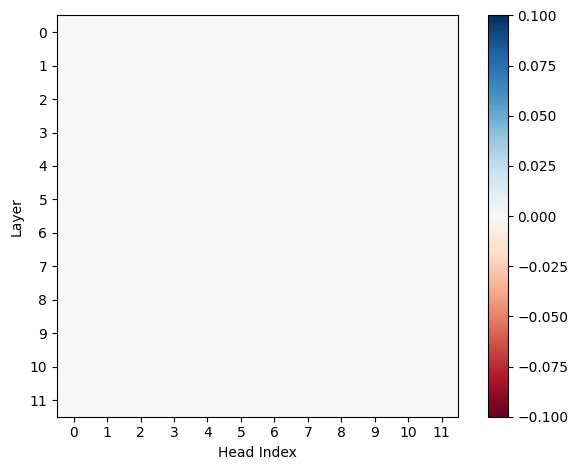

Layer 5, Head 5: 0.0


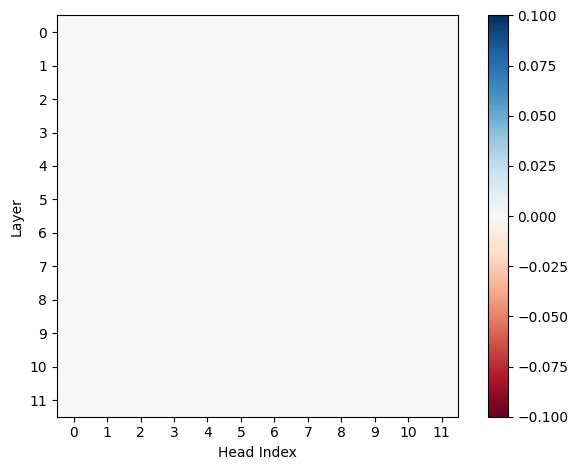

Layer 7, Head 3: 0.0


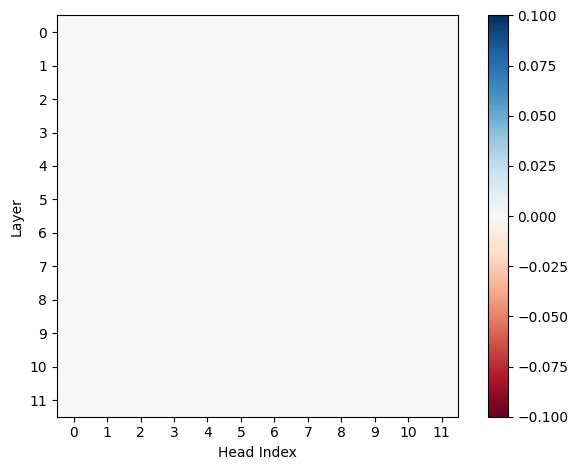

Layer 7, Head 9: 0.0


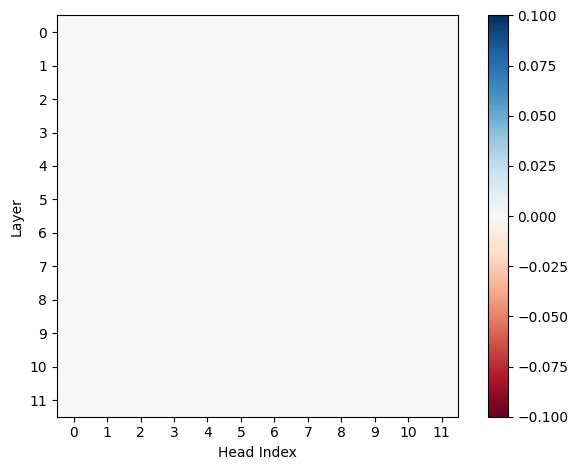

Layer 8, Head 6: 0.0


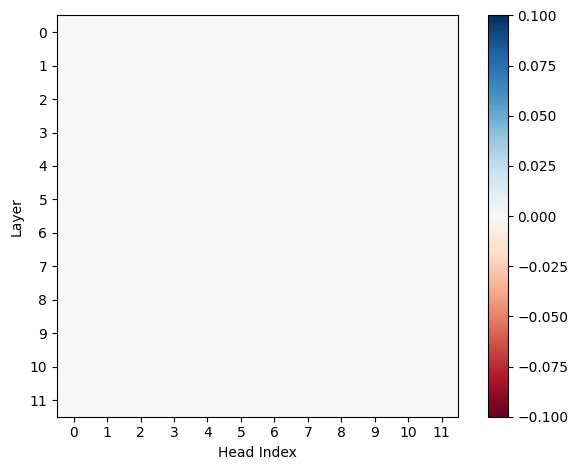

Layer 8, Head 10: -1.227975273548898e-11


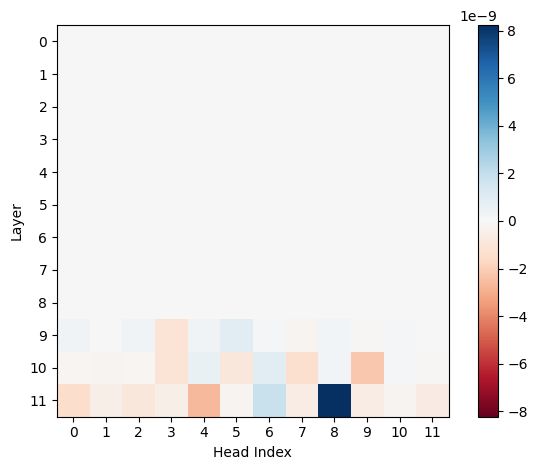

Layer 9, Head 3: 0.0


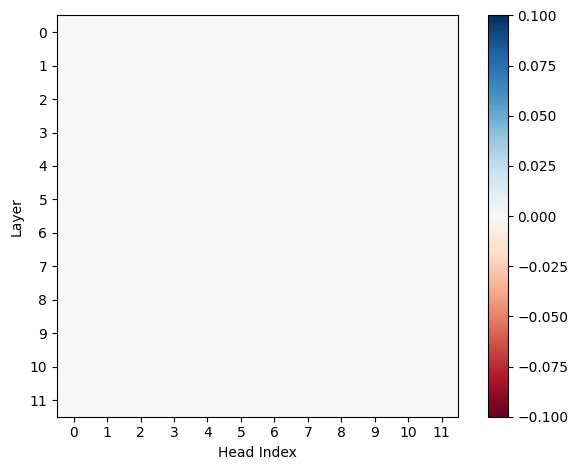

Layer 9, Head 8: 0.0


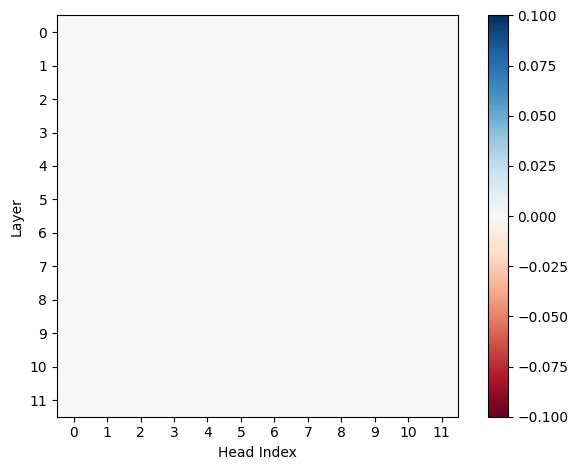

In [53]:
# Sanity check: does ablation matrix pick up components highlighted by IG?
attn_corrupt_clean_indices = highlight_components(attn_corrupt_clean)[1]
for _, layer, idx in attn_corrupt_clean_indices:
    act_diff = ablation_act_diff_attn[layer * model.cfg.n_heads + idx]
    print(f"Layer {layer}, Head {idx}: {act_diff.mean()}")
    plot_attn(act_diff, model)

Layer 0, Head 1: 0.0


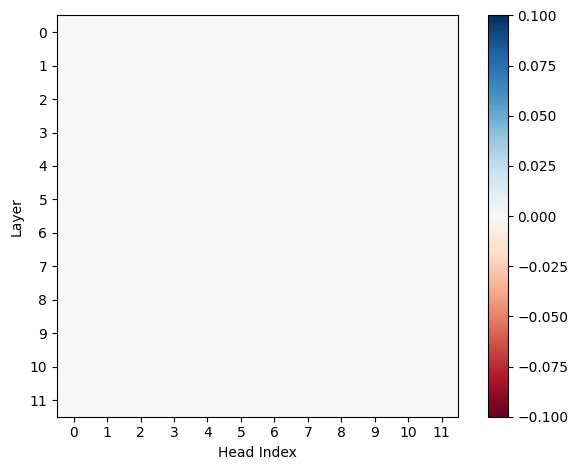

Layer 0, Head 4: 0.0


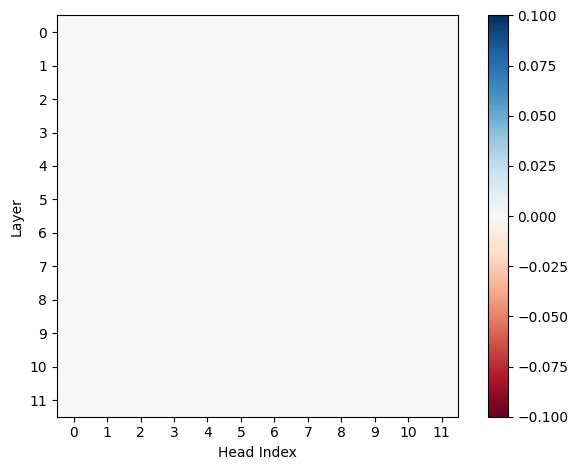

Layer 3, Head 0: 0.0


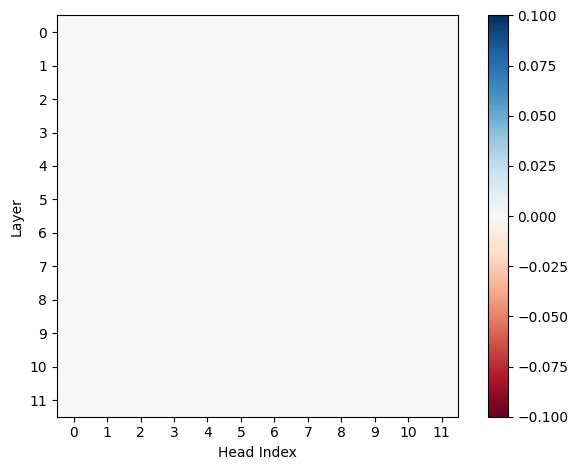

Layer 5, Head 5: 0.0


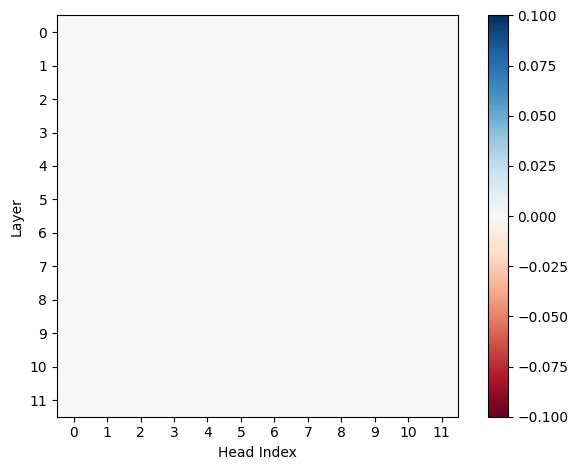

Layer 5, Head 8: 0.0


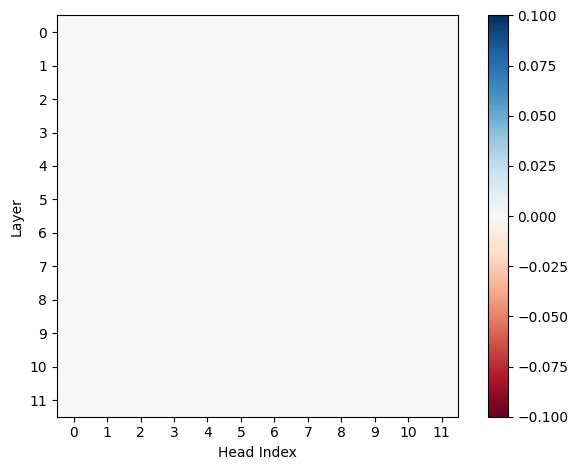

Layer 6, Head 9: 0.0


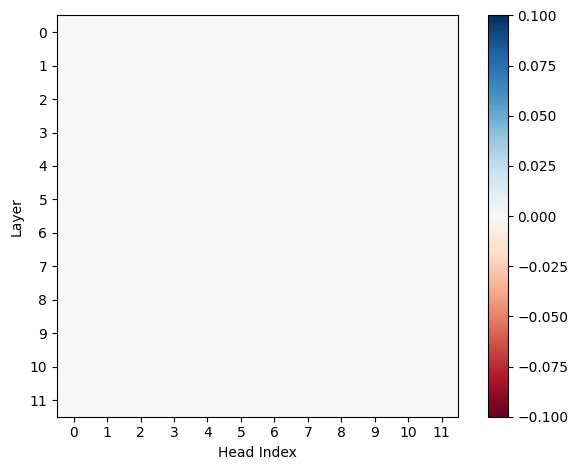

Layer 7, Head 3: 0.0


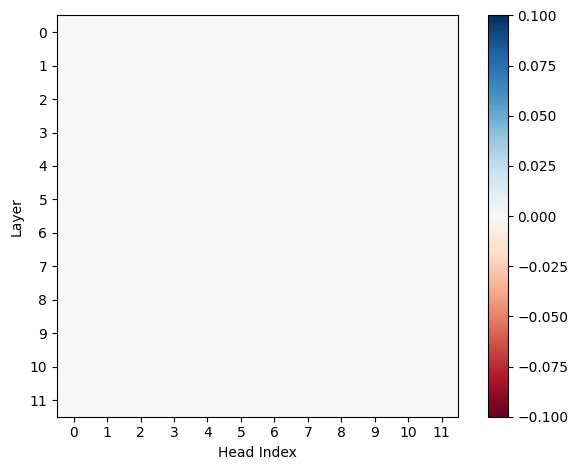

Layer 7, Head 9: 0.0


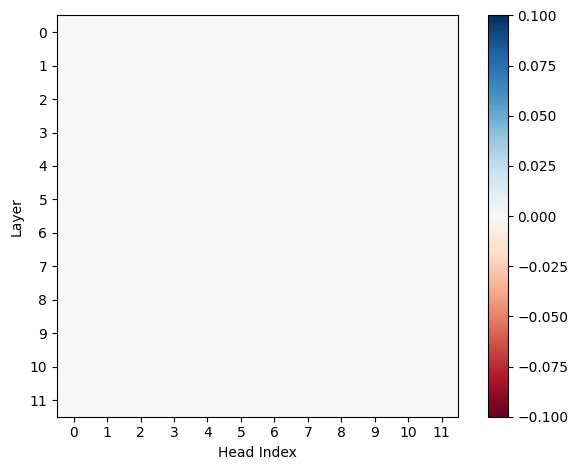

Layer 8, Head 6: 0.0


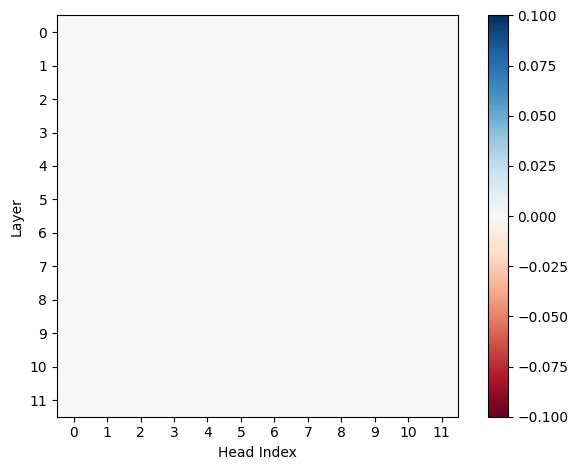

Layer 8, Head 10: -1.227975273548898e-11


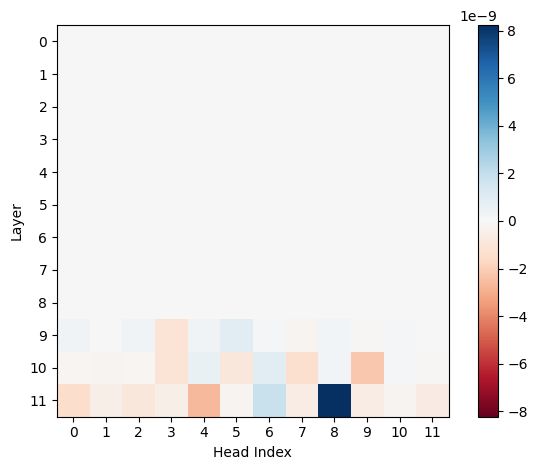

Layer 10, Head 7: 0.0


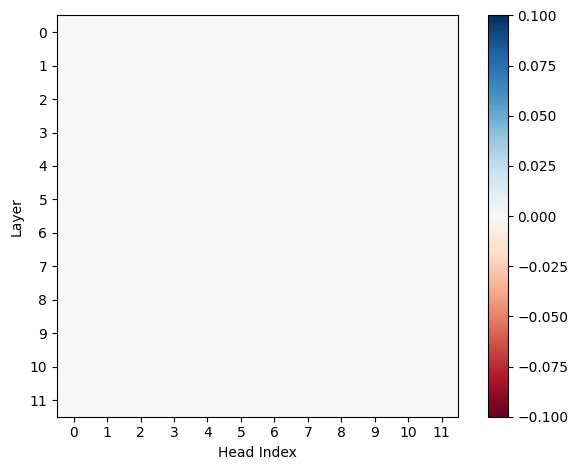

In [ ]:
latent_act_diffs = {"None": baseline_act_diff_attn}

for _, layer, idx in attn_latent_indices:
    act_diff = ablation_act_diff_attn[layer * model.cfg.n_heads + idx]
    latent_act_diffs[(layer, idx)] = act_diff

    print(f"Layer {layer}, Head {idx}: {act_diff.mean()}")
    plot_attn(act_diff, model)

In [60]:
latent_mlp_diffs = {"None": baseline_act_diff_mlp}
print("Baseline MLP activation difference:", baseline_act_diff_mlp.item())

latent_mlp_diffs_mean = {"None": baseline_act_diff_mlp}

for _, layer, idx in mlp_latent_indices:
    act_diff = ablation_act_diff_mlp[layer * model.cfg.d_mlp + idx]
    latent_mlp_diffs[(layer, idx)] = act_diff

    print(f"Layer {layer}, Neuron {idx}: {act_diff.mean()}")
    latent_mlp_diffs_mean[(layer, idx)] = act_diff.mean()

Baseline MLP activation difference: -2.93768675874162e-06
Layer 0, Neuron 21: 2.6058925868710503e-05
Layer 0, Neuron 26: 2.6058925868710503e-05
Layer 0, Neuron 177: 2.6058925868710503e-05
Layer 0, Neuron 302: 2.6058925868710503e-05
Layer 0, Neuron 330: 2.6058925868710503e-05
Layer 0, Neuron 380: 2.6058925868710503e-05
Layer 0, Neuron 483: 2.6058925868710503e-05
Layer 0, Neuron 521: 2.6058925868710503e-05
Layer 0, Neuron 601: 2.6058925868710503e-05
Layer 0, Neuron 711: 2.6058925868710503e-05
Layer 0, Neuron 1005: 2.6058925868710503e-05
Layer 0, Neuron 1085: 2.6058925868710503e-05
Layer 0, Neuron 1089: 2.6058925868710503e-05
Layer 0, Neuron 1100: 2.6058925868710503e-05
Layer 0, Neuron 1145: 2.6058925868710503e-05
Layer 0, Neuron 1160: 2.6058925868710503e-05
Layer 0, Neuron 1233: 2.6058925868710503e-05
Layer 0, Neuron 1391: 2.6058925868710503e-05
Layer 0, Neuron 1404: 2.6058925868710503e-05
Layer 0, Neuron 1457: 2.6058925868710503e-05
Layer 0, Neuron 1463: 2.6058925868710503e-05
Layer 0, 

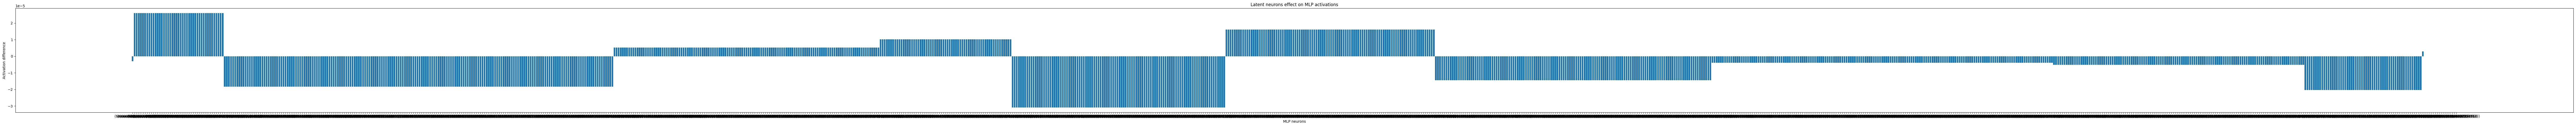

In [63]:
import matplotlib.pyplot as plt

categories = [str(k) for k in latent_mlp_diffs_mean.keys()]
values = [x.item() if isinstance(x, Tensor) else x for x in latent_mlp_diffs_mean.values()]

plt.figure(figsize=(100,5))
plt.bar(categories, values)

plt.xlabel("MLP neurons")
plt.ylabel("Activation difference")
plt.title("Latent neurons effect on MLP activations")

plt.tight_layout()
plt.show()

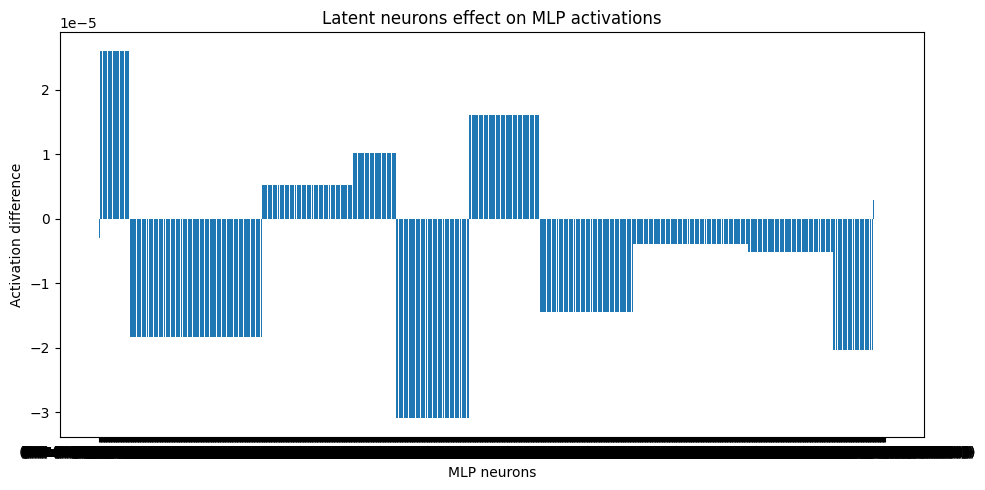

In [61]:
plot_bar_chart(latent_mlp_diffs_mean, "MLP neurons", "Activation difference", "Latent neurons effect on MLP activations")